## Bank Note Authentication Using Deep Neural Networks

<blockquote>In this notebook, I have tried to predict whether a particular instance of a bank note is fake or real.<br>

<b>Dataset</b>
<hr>
<ol>
<li>This data has been taken from the UCI Machine Learning Repository</li>
<li>Data were extracted from images that were taken from genuine and forged banknote-like specimens. For digitization, an industrial camera usually used for print inspection was used </li>
<li>The final images have 400x 400 pixels. Due to the object lens and distance to the investigated object gray-scale pictures with a resolution of about 660 dpi were gained. Wavelet Transform tool were used to extract features from images</li>
<li>It consists of a total of 1373 instances</li></ol>

<b>About the features</b>

<hr>
<ol>
<li>Variance : variance of Wavelet Transformed image (continuous) </li>
<li>Skewness : skewness of Wavelet Transformed image (continuous) </li>
<li>Curtosis : curtosis of Wavelet Transformed image (continuous) </li>
<li>Entropy : entropy of image (continuous) </li>
<li>Class : class (integer - 0(Fake) or 1(Real))</li> </ol>
<br>
The first step is to import the relevant libraries
<br>
</blockquote>

The first step is to import the relevant libraries

In [15]:
#Importing the relevant libraries
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

<blockquote>
In the following blocks of code, I have implemented two mathematical functions that we will be using as activation functions in our network<br>
    <ol>
        <li> Sigmoid Function : It is differentiable everywhere so gradiant descent approach can be used for back propagation.It also outputs probability values between 0 or 1.</li>
        <li> Relu Function : There is a reduced likelihood of vanishing gradient with this function.It is also more computationally efficient than other functions as it needs to only select between (0,z) where z is the input to the function</li>
    </ol>
    
Additionally, by methods of calculus, I have implemented two more functions {relu_backward,sigmoid_backward} that calculate the differentiation value of sigmoid and relu functions respectively. These, I have used during backpropagation for weight and bias vector updation.


</blockquote>

In [2]:
def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

In [3]:
def relu(Z):
    """
    Implements the RELU function.

    Arguments:
    Z -- Output of the linear layer, of any shape

    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache

In [35]:
def relu_backward(dA, cache):
    """
    Implements the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, we set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [36]:
def sigmoid_backward(dA, cache):
    """
    Implements the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

<blockquote>

The neural network (with L layers) I have implemented has Relu activation functions until the (L-1)th layer and Sigmoid function at the Lth layer

We can see, from the code below, that in a for loop that goes from 1 to L-1, I have initialized each layer's W using He initialization to regularise the model so that it does not suffer from high variance eventually.

Since it is alright to initialise the b vector to all zeros, I have simply done that.

</blockquote>

In [6]:
def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        
        
        #He initialization
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1])*math.sqrt(2./layers_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters


<blockquote>
In the following code, I have implemented linear_forward which takes as input the activation output of the previous layer (X = A[0]), the corresponding weight and bias matrix for the current layer<br>
    <br>
    
We calculate Z = W.dot(A_prev) + b
    
    
    
</blockquote>
    

In [7]:
def linear_forward(A, W, b):
    """
    Implements the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    Z = W.dot(A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

<blockquote>
    
In the following code snippet, I have implemented a function that calls the previous function (linear_forward) based on whether the activation is sigmoid or Relu. It would call linear_forward with activation = "relu" for a total of L-1 layers before it calls linear_forward with activation = "sigmoid" for the Lth layer


Additionally, linear_activation_forward returns a cache that is a combination of linear_cache which stores the Z matrix where<br> 
Z = W*Aprev + b <br>
and activation_cache stores the value of A where A = g(Z) where g is our activation function (sigmoid/relu)
    
    
    
    
</blockquote>

In [8]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Implements the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

<blockquote>
In the following code, I have implemented L_model_forward, which calls linear_activation_forward L-1 times with activation = "relu" and one more time for the Lth layer with activation = "sigmoid"
<br>
    <br>
    
Additionally, "cache" will store all the caches (linear cache,activation cache) for each layer. "caches" is a combination of all such "cache" which is the second parameter returned by L_model_forward



</blockquote>

In [9]:
def L_model_forward(X, parameters):
    """
    Implements forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
                the cache of linear_sigmoid_forward() (there is one, indexed L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implementing [LINEAR -> RELU]*(L-1).
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)
    
    # Implementing LINEAR -> SIGMOID for the Lth layer
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches


<blockquote>

In the following function, compute_cost, we calculate the cost of a neural network model with a binary classification output of 0 or 1. From calculus, we see that :<br>
<br>
cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))<br>
<br>
is the most efficient way to calculate the cost. If ycap is our prediction and y is our true label, we see tat upon substituting y = 1 in the above function, this cost equation forces ycap to be 1 in order to minimize the loss to approximately 0 and vice versa for y = 0.



</blockquote>

In [10]:
def compute_cost(AL, Y):
    """
    Implements the cost function for a binary classification problem
    
    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]

    # Compute loss from aL and y.
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    
    cost = np.squeeze(cost)      # this turns [[17]] into 17
    assert(cost.shape == ())
    
    return cost

<blockquote>

In the following function, linear_backward, I have calculated dW and dB given dZ of that current layer and cache which stores (A_prev,W and b) from forward propagation for that layer. 




</blockquote>

In [11]:
def linear_backward(dZ, cache):
    """
    Implements the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

<blockquote>

The following function linear_activation_backward calls the appropriate function (relu_backward/sigmoid_backward) based on what the activation value is (relu/sigmoid). Essentially, it makes this call to calculate dA_prev which is the differential value of the activation function of the previous layer.



</blockquote>

In [12]:
def linear_activation_backward(dA, cache, activation):
    """
    Implements the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

<blockquote>

L_model_backward runs the main function for backpropagation for the whole model, where it calls linear_activation_backward once for the Lth layer with activation = "sigmoid" and otherwise L-1 times with activation = "relu"


</blockquote>

In [13]:
def L_model_backward(AL, Y, caches):
    """
    Implements the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if note is fake, 1 if note is real)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (there are (L-1) or them, indexes from 0 to L-2)
                the cache of linear_activation_forward() with "sigmoid" (there is one, index L-1)
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

<blockquote>
update_parameters will update W and b based on the differentiation parameters that it receives after calculation and also the learning rate(alpha). It will do so for each layer in the neural network.

</blockquote>

In [14]:
def update_parameters(parameters, grads, learning_rate):
    """
    Updates parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

<blockquote>
    load_data_csv : Loads data from the designated folder in "csv" format. It also splits the data as follows:
    train -> 80%
    test -> 20%
    <br>
    <br>
    Eventually, we will reshape the data to the appropriate dimensions in order to pass as input to initialize_parameters_deep
    
    
    
    
    
</blockquote>

In [25]:
def load_data_csv(name_of_file):
    path = r'C:\Users\Aishwarya\Desktop\Desktop\UdemyCoursera\BankNoteAuthentication\\'
    full_dataset = pd.read_csv(path+name_of_file)
    
    train, test = train_test_split(full_dataset, test_size=0.2)
    
    train_set_x = np.array(train.iloc[:,0:4])
    train_set_y = np.array(train.iloc[:,4])
    
    test_set_x = np.array(test.iloc[:,0:4])
    test_set_y = np.array(test.iloc[:,4])
    
    
    train_set_y = train_set_y.reshape((1, train_set_y.shape[0]))
    test_set_y = test_set_y.reshape((1, test_set_y.shape[0]))
    
    #print(train_set_x.shape)
    #print(test_set_y.shape)
    
    return train_set_x,train_set_y,test_set_x,test_set_y

In [26]:
train_x_orig, train_y, test_x_orig, test_y = load_data_csv('banknote.csv')

In [27]:
# Exploring our dataset 
m_train = train_x_orig.shape[0]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 1097
Number of testing examples: 275
train_x_orig shape: (1097, 4)
train_y shape: (1, 1097)
test_x_orig shape: (275, 4)
test_y shape: (1, 275)


In [30]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (4, 1097)
test_x's shape: (4, 275)


<blockquote>
    We define our network as follows:
    <ol>
        <li> Input layer : 4 neurons, each corresponding to one feature of the input observation</li>
        <li> 1st Hidden layer : 20 neurons</li>
        <li> 2nd Hidden layer : 100 neurons</li>
        <li> 3rd Hidden layer : 75 neurons</li>
        <li> 4th Hidden layer : 50 neurons</li>
        <li> 5th Hidden layer : 20 neurons</li>
        <li> 6th Hidden layer : 10 neurons</li>
        <li> Output Layer : 1 neuron</li></ol>
    
   Here, we purposely select a neural network which is very deep with so many layers, because we have very less data at hand, so in order to combat the problem of high bias, we will make the neural network more complex. Since there is very less data, we do not need to do mini-batch processing as we have enough computational memory to run around 1300 observations which would not even take much time.
    
    
    
    
   </blockquote>

In [19]:
### CONSTANTS ###
layers_dims = [4,20,100, 75,50,20,10,1] #  7-layer model

<blockquote>
    
   L_layer_model will call the appropriate neural network functions defined above and calculate the cost of our model after every 1000 iterations. It will do so as many times as the value of num_iterations which is the epoch value that we will input for our model.
    
    
   </blockquote>

In [21]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization
    parameters = initialize_parameters_deep(layers_dims)
    
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X,parameters)
        
        
        # Compute cost.
        cost = compute_cost(AL,Y)
    
        # Backward propagation.
        grads = L_model_backward(AL,Y,caches)
     
        # Update parameters.
        parameters = update_parameters(parameters,grads,learning_rate)
                
        # Print the cost every 1000 training example
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 1000 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per 000s)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

<blockquote>
    
   Now, we will run our model, and note the cost after every 1000 iterations. Plotting a graph of cost after every 1000 iterations shows us how our model reaches the appropriate optimal value.
    
    
    
   </blockquote>

Cost after iteration 0: 0.694189
Cost after iteration 1000: 0.524189
Cost after iteration 2000: 0.497194
Cost after iteration 3000: 0.449796
Cost after iteration 4000: 0.402558
Cost after iteration 5000: 0.216739
Cost after iteration 6000: 0.128143
Cost after iteration 7000: 0.074602


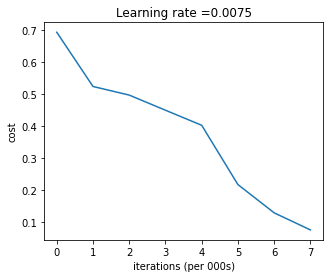

In [31]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 8000, print_cost = True)

<blockquote>
  
  Now, we predict our model's performance on unseen-data(test data)
    
    
    
   </blockquote>

In [32]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p


In [33]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9644484958979032


In [34]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.9636363636363636


<blockquote>
    
   We can see that our model, performs very well on both train as well as test data. This suggests, that we have low variance and low bias and we are not overfitting our model on training data.
    
    
  </blockquote>